In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        # transforms.Normalize(mean, std),
        # lambda x: torch.flip(x, [1]),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)
dataset = torchvision.datasets.ImageFolder(
    root="./data/caltech101/train",
    transform=transform,
)

valset = torchvision.datasets.ImageFolder(
    root="./data/caltech101/val",
    transform=transform,
)

testset = torchvision.datasets.ImageFolder(
    root="./data/caltech101/test",
    transform=transform,
)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=128, shuffle=False, num_workers=2
)

valloader = torch.utils.data.DataLoader(
    valset, batch_size=128, shuffle=False, num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2
)

In [2]:
from cbir import *
from cbir.pipeline import *

rgb_histogram = RGBHistogram(n_bin=8, h_type="region")
resnet = ResNetExtractor(model = "resnet18", device="cuda")
siftbow = SIFTBOWExtractor(mode="tfidf")
# vgg16 = VGG16Extractor(device="cuda")
array_store = NPArrayStore(retrieve=KNNRetrieval(metric="cosine"))

In [3]:
from tqdm import tqdm
import numpy as np
train_img = []
for images, labels in tqdm(valloader):
    images = (images.numpy().transpose(0,2,3,1) * 255).astype(np.uint8)
    train_img.append(images)
    
train_img = np.concatenate(train_img)
siftbow.fit(train_img, k=64)

  0%|          | 0/11 [00:00<?, ?it/s]/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

Fit Kmeans clustering to create BOW
Fit IDF for TF-IDF Transformation
Complete Fitting SIFT BOW Extractor


In [4]:
cbir = CBIR(resnet, array_store)

In [5]:
for images, labels in tqdm(dataloader):
    # images = (images.numpy().transpose(0,2,3,1) * 255).astype(np.uint8)
    images = images.numpy()
    cbir.indexing(images)

  0%|          | 0/50 [00:00<?, ?it/s]/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

In [7]:
cbir.feature_extractor.mode = "tfidf"

In [8]:
img = cv2.imread("/home/edtechai/works/vunt/CV-basic/data/caltech101/test/ant/image_0024.jpg")
img = transform(img)
# img = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)
img = img.unsqueeze(0).numpy()

/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
# rs = cbir.retrieve(np.expand_dims(img, axis=0), k=5)
rs = cbir.retrieve(img, k=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0010572566..1.0000001].


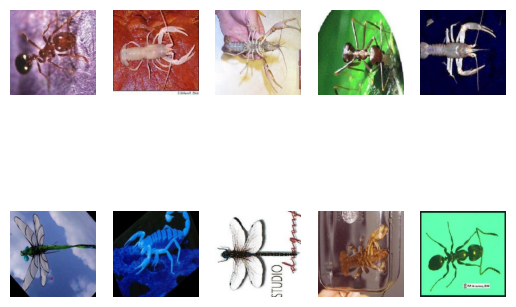

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,5)
for i, r in enumerate(rs[0]):
    ax[i // 5][i % 5].imshow(r.image.transpose((1, 2, 0)))
    # ax[i // 5][i % 5].imshow(r.image)
    ax[i // 5][i % 5].axis("off")
plt.show()

In [19]:
rs = []
ground_truth = []
for images, labels in tqdm(testloader):
    # images = (images.numpy().transpose(0,2,3,1) * 255).astype(np.uint8)
    images = images.numpy()
    rs.extend(cbir.retrieve(images, k=10))
    ground_truth.extend(labels)

  0%|          | 0/12 [00:00<?, ?it/s]/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

In [20]:
np.take(dataset.targets, predicted, axis=0)

array([101, 101, 101, 101, 101, 101, 101, 101, 101, 101])

In [43]:
def average_precision(predictions, ground_truths, k):
    top_k_predictions = predictions[:k]
    
    relevant_items = sum(1 for pred in top_k_predictions if pred in ground_truths)
    
    ap = relevant_items / len(top_k_predictions)
    
    return ap

def hit_rate(predictions, ground_truths, k):
    top_k_predictions = predictions[:k]
    
    relevant_items = sum(1 for pred in top_k_predictions if pred in ground_truths)
    
    hit = 1 if relevant_items >= 1 else 0
    
    return hit

In [44]:
ap = []
hit = []
for r, g in zip(rs, ground_truth):
    predicted = []
    for i in r:
        predicted.append(i.index)
    class_preds = np.take(dataset.targets, predicted, axis=0)
    ap.append(average_precision(class_preds.tolist(), [g.tolist()], 10))
    hit.append(hit_rate(class_preds.tolist(), [g.tolist()], 10))

In [ ]:
pd.concat

In [46]:
np.mean(ap)
np.mean(hit)

0.9494880546075085

In [49]:
import pandas as pd
pd.DataFrame({"options": [1], "map": [np.mean(ap)], "hit_rate": [np.mean(hit)]})

,options,map,hit_rate
0,1,0.73802,0.949488


In [12]:
def grid(*args):
    if len(args) == 1:
        for k in args[0]:
            yield [k]
    else:
        for k in args[0]:
            for rest in grid(*args[1:]):
                yield([k] + rest)

In [13]:
for a in grid([1, 2, 3], [4, 5, 6]):
    print(a)

[1, 4]
[1, 5]
[1, 6]
[2, 4]
[2, 5]
[2, 6]
[3, 4]
[3, 5]
[3, 6]


In [5]:
for p in {"a": [1, 3, 4], "b": [12, 5, 7]}:
    break

p

'a'